In [1]:
#!pip install wordcloud
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

In [2]:
data=pd.read_csv("ds_salaries.csv")

In [3]:
print(data.shape)

(3755, 11)


In [4]:
data.head()

work_year experience_level employment_type                 job_title  \
0       2023               SE              FT  Principal Data Scientist   
1       2023               MI              CT               ML Engineer   
2       2023               MI              CT               ML Engineer   
3       2023               SE              FT            Data Scientist   
4       2023               SE              FT            Data Scientist   

   salary salary_currency  salary_in_usd employee_residence  remote_ratio  \
0   80000             EUR          85847                 ES           100   
1   30000             USD          30000                 US           100   
2   25500             USD          25500                 US           100   
3  175000             USD         175000                 CA           100   
4  120000             USD         120000                 CA           100   

  company_location company_size  
0               ES            L  
1               US            S  
2               US            S  
3               CA            M  
4               CA            M

In [5]:
data.nunique()

work_year                4
experience_level         4
employment_type          4
job_title               93
salary                 815
salary_currency         20
salary_in_usd         1035
employee_residence      78
remote_ratio             3
company_location        72
company_size             3
dtype: int64

In [6]:
data.isnull().sum()

work_year             0
experience_level      0
employment_type       0
job_title             0
salary                0
salary_currency       0
salary_in_usd         0
employee_residence    0
remote_ratio          0
company_location      0
company_size          0
dtype: int64

In [7]:
data.duplicated().sum()

1171

In [8]:
data = data.drop_duplicates()

In [9]:
data.duplicated().sum()

0

In [10]:
data.dtypes

work_year              int64
experience_level      object
employment_type       object
job_title             object
salary                 int64
salary_currency       object
salary_in_usd          int64
employee_residence    object
remote_ratio           int64
company_location      object
company_size          object
dtype: object

In [11]:
numerical_columns=data.select_dtypes(include=['int64']).columns
categorical_columns=data.select_dtypes(include=['object']).columns

In [12]:
numerical_columns

Index(['work_year', 'salary', 'salary_in_usd', 'remote_ratio'], dtype='object')

In [13]:
categorical_columns

Index(['experience_level', 'employment_type', 'job_title', 'salary_currency',
       'employee_residence', 'company_location', 'company_size'],
      dtype='object')

In [14]:
data.describe()

work_year        salary  salary_in_usd  remote_ratio
count  2584.000000  2.584000e+03    2584.000000   2584.000000
mean   2022.301084  2.103653e+05  133409.280186     50.483746
std       0.749179  8.080375e+05   67136.837329     48.163707
min    2020.000000  6.000000e+03    5132.000000      0.000000
25%    2022.000000  9.000000e+04   84975.000000      0.000000
50%    2022.000000  1.346300e+05  130000.000000     50.000000
75%    2023.000000  1.825625e+05  175000.000000    100.000000
max    2023.000000  3.040000e+07  450000.000000    100.000000

In [15]:
iso_forest=IsolationForest(contamination=0.05, random_state=42)
outliers = iso_forest.fit_predict(data[numerical_columns])
outlier_count = (outliers == -1).sum()
total_count = len(outliers)
outlier_percentage = (outlier_count / total_count) * 100
print(f"Percentage of numerical outliers: {outlier_percentage:.2f}%")

Percentage of numerical outliers: 5.03%


C:\Users\nipun\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


In [16]:
cat_outliers = {}
cat_outlier_count = 0

for col in categorical_columns:
    value_counts = data[col].value_counts()
    rare_categories = value_counts[value_counts < 0.05 * len(data)]
    cat_outliers[col] = rare_categories.index.tolist()
    cat_outlier_count += data[col].isin(rare_categories.index).sum()

total_count = len(data)

categorical_outlier_percentage = (cat_outlier_count / total_count) * 100

print(f"Categorical outliers count: {cat_outlier_count}")
print(f"Categorical outliers percentage: {categorical_outlier_percentage:.2f}%")

Categorical outliers count: 2153
Categorical outliers percentage: 83.32%


In [17]:
data['salary_category'] = pd.cut(
    data['salary_in_usd'],
    bins=[0, 100000, 200000, float('inf')],
    labels=['salary<100,000 USD', '100,000≤salary<200,000 USD', 'salary≥200,000 USD']
)

data[['salary_in_usd', 'salary_category']].head()


salary_in_usd             salary_category
0          85847          salary<100,000 USD
1          30000          salary<100,000 USD
2          25500          salary<100,000 USD
3         175000  100,000≤salary<200,000 USD
4         120000  100,000≤salary<200,000 USD

In [18]:
def ratio_class(ratio):
    if ratio == 100:
        return 'Remote'
    elif ratio == 0:
        return 'In-Person'
    else:
        return 'Hybrid'

In [19]:
data['ratio_class'] = data['remote_ratio'].apply(ratio_class)
data['ratio_class'].value_counts()

ratio_class
Remote       1211
In-Person    1186
Hybrid        187
Name: count, dtype: int64

In [20]:
# Experience level
data['experience_level'] = data['experience_level'].replace(
    {'EN': 'Entry-Level',
     'MI': 'Mid-Level',
     'SE': 'Senior',
     'EX': 'Executive'} 
)

# Company Size
data['company_size'] = data['company_size'].replace(
    {'S': 'Small',
     'M': 'Medium',
     'L': 'Large'}
)

In [21]:
def assign_broader_category(job_title):
    data_engineering = ["Data Engineer", "Data Analyst", "Analytics Engineer", "BI Data Analyst", "Business Data Analyst", "BI Developer", "BI Analyst", "Business Intelligence Engineer", "BI Data Engineer", "Power BI Developer"]
    data_scientist = ["Data Scientist", "Applied Scientist", "Research Scientist", "3D Computer Vision Researcher", "Deep Learning Researcher", "AI/Computer Vision Engineer"]
    machine_learning = ["Machine Learning Engineer", "ML Engineer", "Lead Machine Learning Engineer", "Principal Machine Learning Engineer"]
    data_architecture = ["Data Architect", "Big Data Architect", "Cloud Data Architect", "Principal Data Architect"]
    management = ["Data Science Manager", "Director of Data Science", "Head of Data Science", "Data Scientist Lead", "Head of Machine Learning", "Manager Data Management", "Data Analytics Manager"]
    
    if job_title in data_engineering:
        return "Data Engineering"
    elif job_title in data_scientist:
        return "Data Science"
    elif job_title in machine_learning:
        return "Machine Learning"
    elif job_title in data_architecture:
        return "Data Architecture"
    elif job_title in management:
        return "Management"
    else:
        return "Other"

data['job_category'] = data['job_title'].apply(assign_broader_category)


In [22]:
data.head()

work_year experience_level employment_type                 job_title  \
0       2023           Senior              FT  Principal Data Scientist   
1       2023        Mid-Level              CT               ML Engineer   
2       2023        Mid-Level              CT               ML Engineer   
3       2023           Senior              FT            Data Scientist   
4       2023           Senior              FT            Data Scientist   

   salary salary_currency  salary_in_usd employee_residence  remote_ratio  \
0   80000             EUR          85847                 ES           100   
1   30000             USD          30000                 US           100   
2   25500             USD          25500                 US           100   
3  175000             USD         175000                 CA           100   
4  120000             USD         120000                 CA           100   

  company_location company_size             salary_category ratio_class  \
0               ES        Large          salary<100,000 USD      Remote   
1               US        Small          salary<100,000 USD      Remote   
2               US        Small          salary<100,000 USD      Remote   
3               CA       Medium  100,000≤salary<200,000 USD      Remote   
4               CA       Medium  100,000≤salary<200,000 USD      Remote   

       job_category  
0             Other  
1  Machine Learning  
2  Machine Learning  
3      Data Science  
4      Data Science

In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2584 entries, 0 to 3754
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   work_year           2584 non-null   int64   
 1   experience_level    2584 non-null   object  
 2   employment_type     2584 non-null   object  
 3   job_title           2584 non-null   object  
 4   salary              2584 non-null   int64   
 5   salary_currency     2584 non-null   object  
 6   salary_in_usd       2584 non-null   int64   
 7   employee_residence  2584 non-null   object  
 8   remote_ratio        2584 non-null   int64   
 9   company_location    2584 non-null   object  
 10  company_size        2584 non-null   object  
 11  salary_category     2584 non-null   category
 12  ratio_class         2584 non-null   object  
 13  job_category        2584 non-null   object  
dtypes: category(1), int64(4), object(9)
memory usage: 285.3+ KB


##  EDA

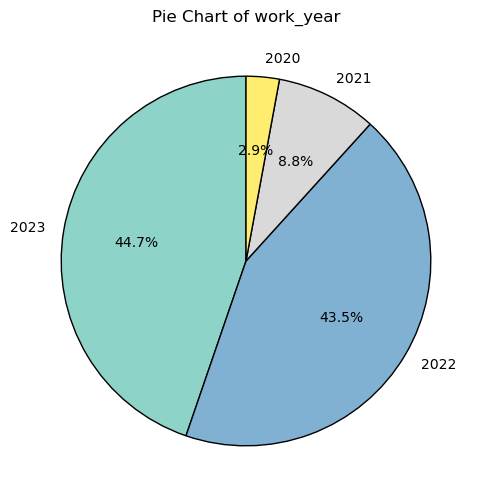

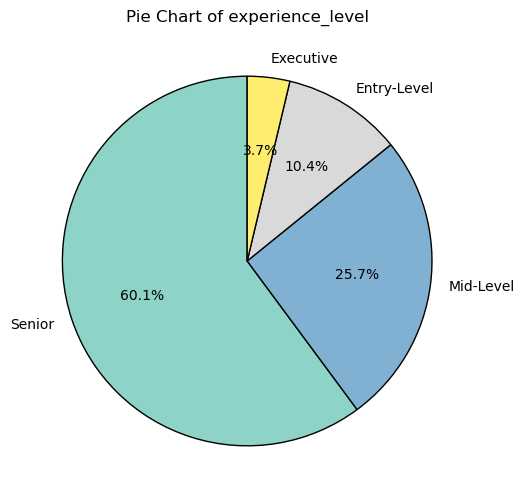

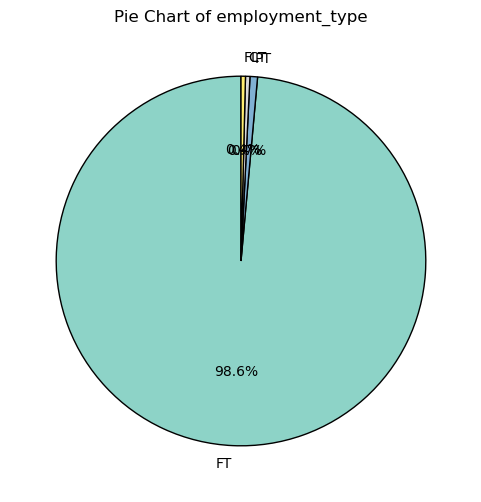

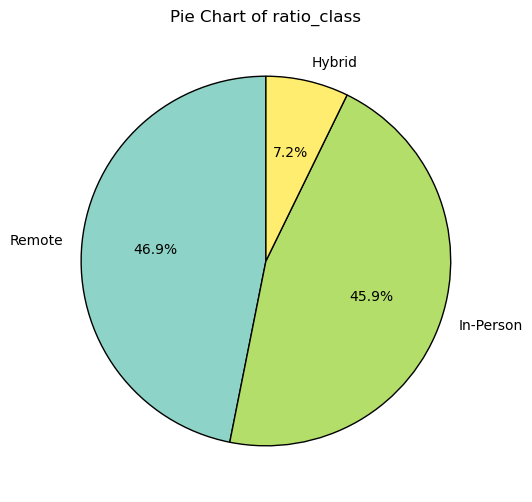

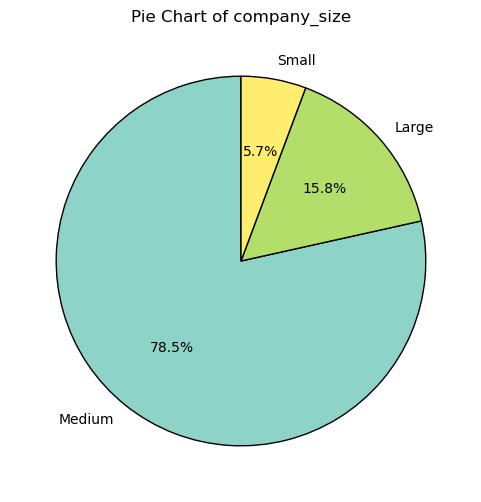

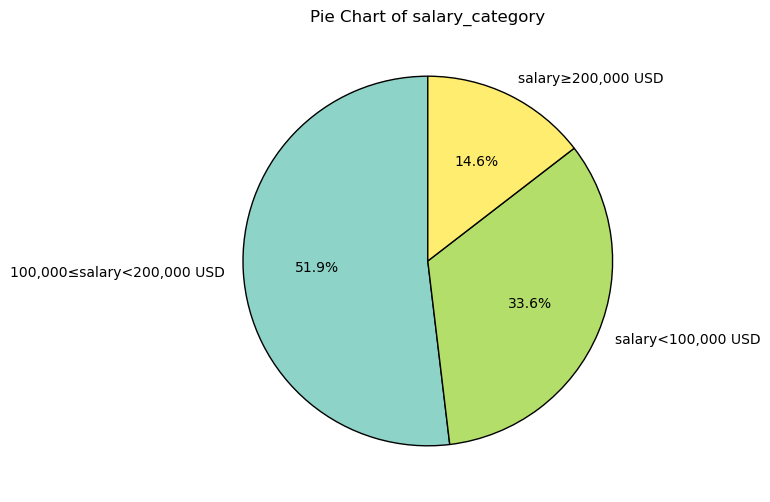

In [24]:
for col in ['work_year','experience_level','employment_type','ratio_class','company_size','salary_category']:
    plt.figure(figsize=(6, 6))
    data[col].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, cmap='Set3', wedgeprops={'edgecolor': 'black'})
    plt.title(f"Pie Chart of {col}")
    plt.ylabel('') 
    plt.show()

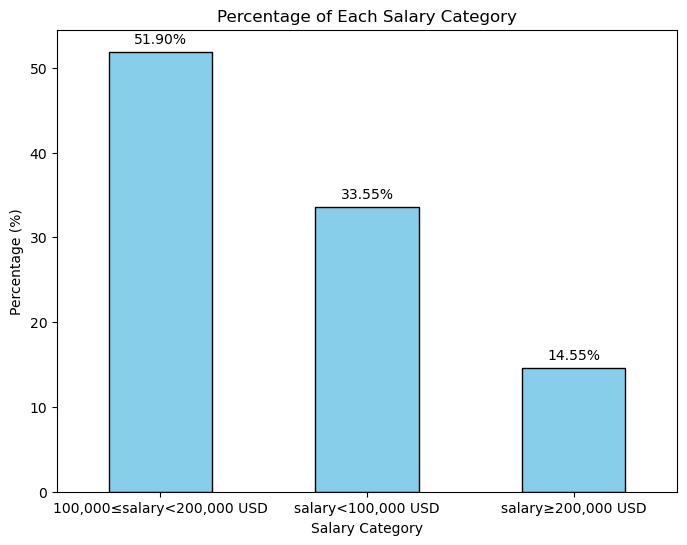

In [25]:
category_counts = data['salary_category'].value_counts(normalize=True) * 100

# Plot the bar chart
plt.figure(figsize=(8, 6))
category_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Percentage of Each Salary Category')
plt.xlabel('Salary Category')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=0)

# Display percentages on top of each bar
for index, value in enumerate(category_counts):
    plt.text(index, value + 1, f'{value:.2f}%', ha='center')

plt.show()

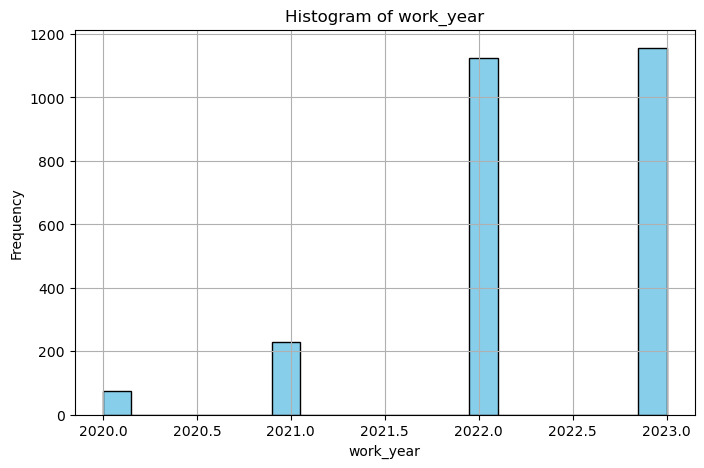

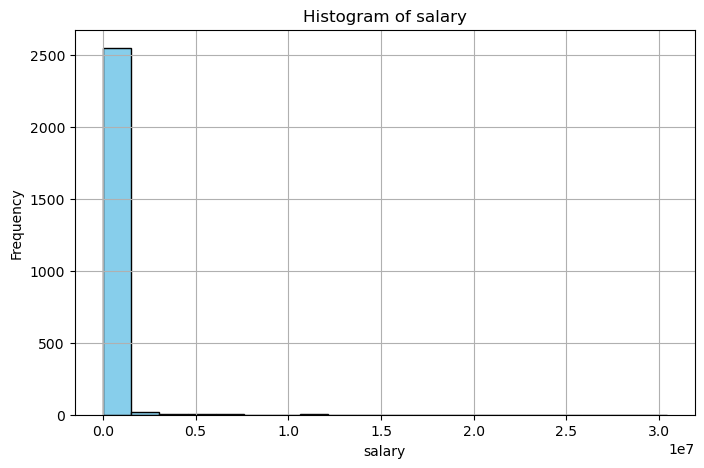

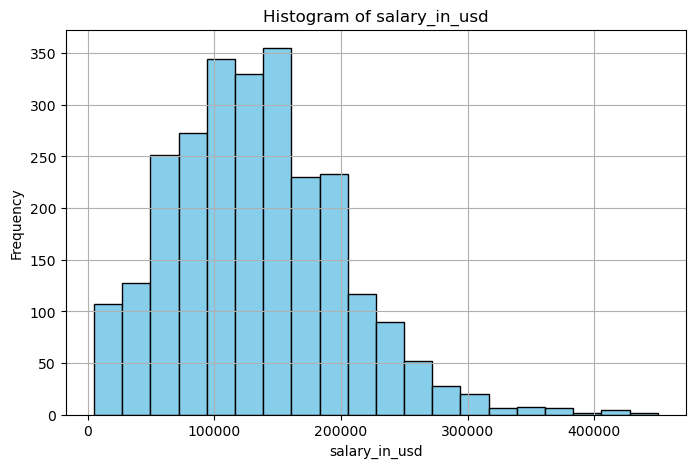

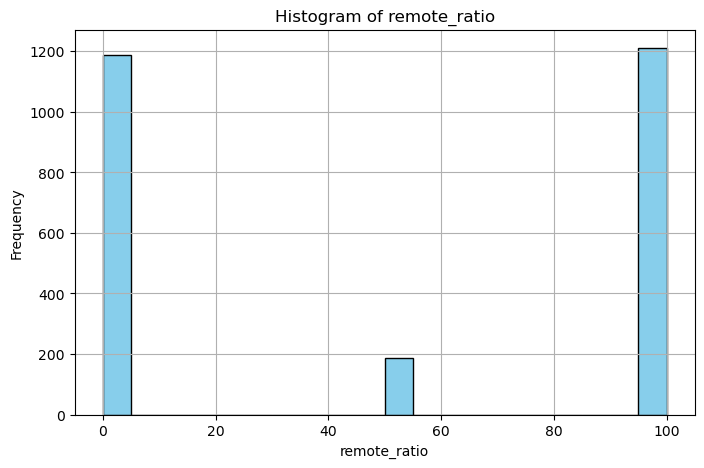

In [26]:
for col in numerical_columns:
    plt.figure(figsize=(8, 5))
    plt.hist(data[col], bins=20, color='skyblue', edgecolor='black')
    plt.title(f"Histogram of {col}")
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

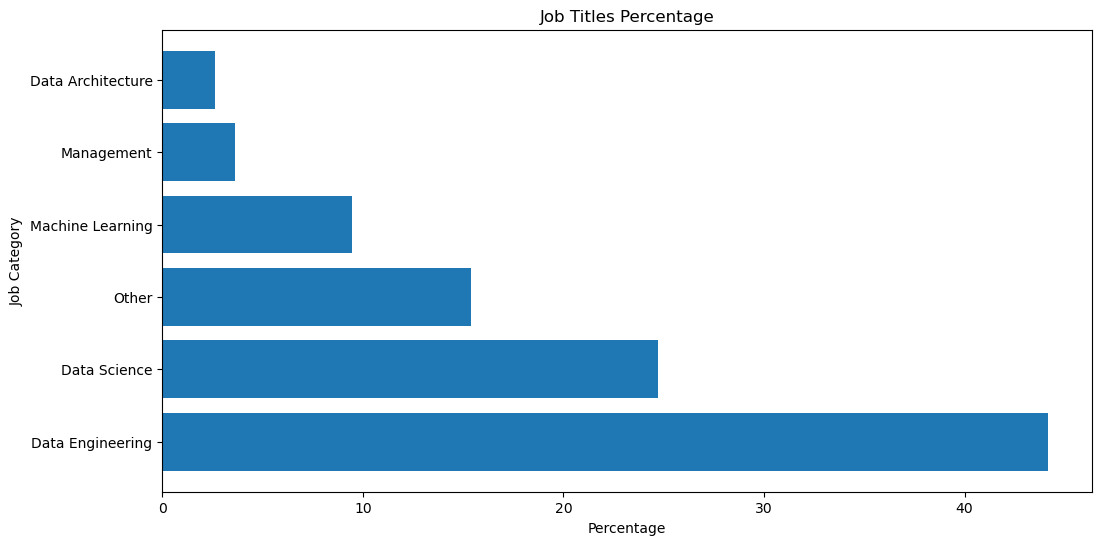

In [27]:
value_counts = data['job_category'].value_counts(normalize=True) * 100

fig, ax = plt.subplots(figsize=(12, 6))
top_n = min(17, len(value_counts))
ax.barh(value_counts.index[:top_n], value_counts.values[:top_n])
ax.set_xlabel('Percentage')
ax.set_ylabel('Job Category')
ax.set_title('Job Titles Percentage')
plt.show()

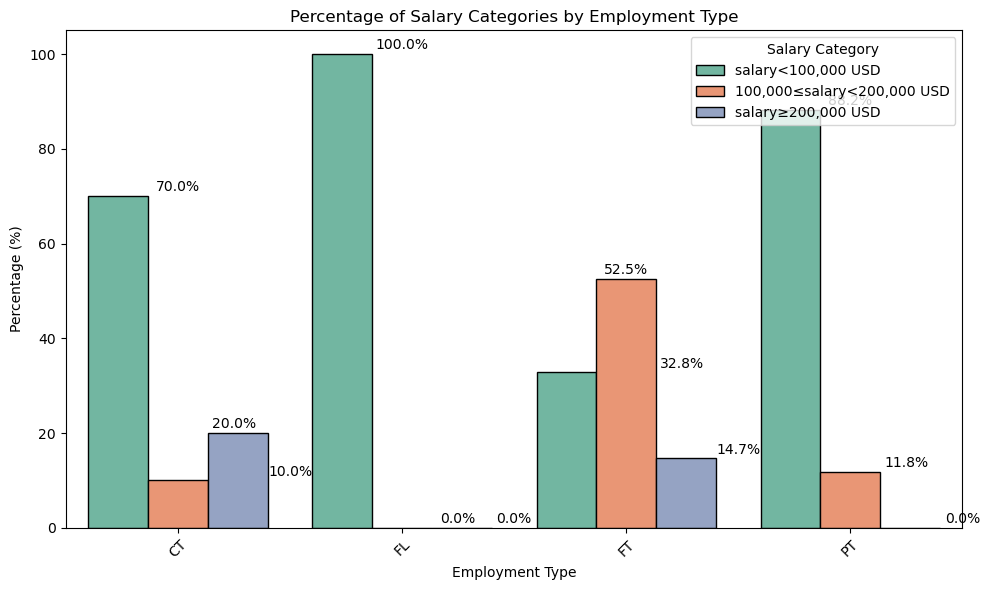

In [28]:
# Calculate the percentage of each salary category within each employment type
category_counts = (
    data.groupby('employment_type')['salary_category']
    .value_counts(normalize=True)
    .rename('percentage')
    .reset_index()
)
category_counts['percentage'] *= 100  # Convert to percentage

# Plot the multiple bar chart
plt.figure(figsize=(10, 6))
sns.barplot(
    data=category_counts,
    x='employment_type',
    y='percentage',
    hue='salary_category',
    palette='Set2',
    edgecolor='black'
)

# Add percentages on top of each bar
for index, row in category_counts.iterrows():
    plt.text(
        index // 3 + (index % 3) * 0.25,  # Adjust x position for multiple bars
        row['percentage'] + 1,
        f"{row['percentage']:.1f}%",
        ha='center'
    )

plt.title('Percentage of Salary Categories by Employment Type')
plt.xlabel('Employment Type')
plt.ylabel('Percentage (%)')
plt.legend(title='Salary Category', loc='upper right')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


C:\Users\nipun\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='salary_in_usd', ylabel='Count'>

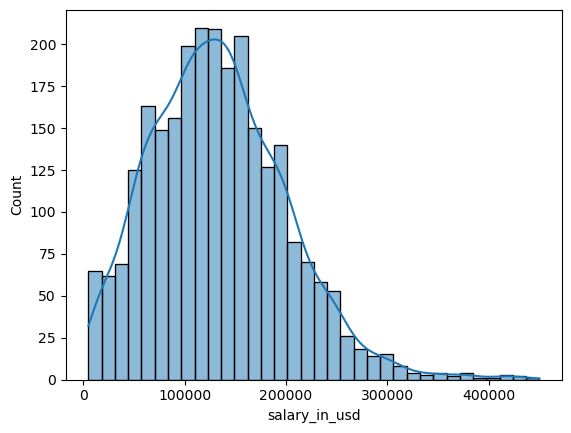

In [29]:
sns.histplot(data['salary_in_usd'], kde=True)

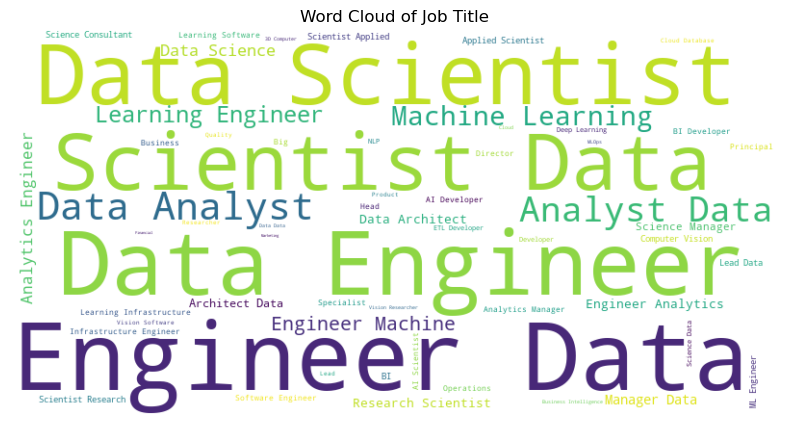

In [30]:
text_data = ' '.join(data['job_title'].dropna())  
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis', max_words=200).generate(text_data)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  
plt.title('Word Cloud of Job Title')
plt.show()

C:\Users\nipun\AppData\Local\Temp\ipykernel_27640\1815980953.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  salary_trend = data.groupby(['work_year', 'salary_category'])['salary_in_usd'].mean().reset_index()
C:\Users\nipun\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\nipun\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\nipun\anaconda3\Lib\site-packages\seaborn\_oldcore.py:

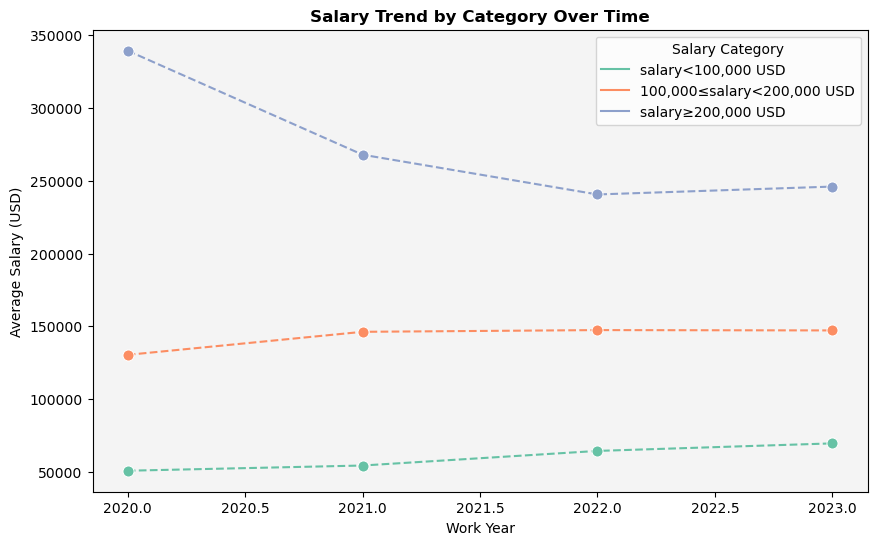

In [31]:
# Calculate the average salary per category for each year
salary_trend = data.groupby(['work_year', 'salary_category'])['salary_in_usd'].mean().reset_index()

plt.figure(figsize=(10, 6))
p = sns.lineplot(
    data=salary_trend,
    x='work_year',
    y='salary_in_usd',
    hue='salary_category',
    marker='o',
    linestyle='--',
    markersize=8,
    palette='Set2'
)

plt.title('Salary Trend by Category Over Time', fontsize=12, fontweight='bold')
p.set_facecolor("#f4f4f4")
plt.xlabel('Work Year')
plt.ylabel('Average Salary (USD)')
plt.legend(title='Salary Category', fontsize=10, loc='best')
p.grid(False)
plt.show()


C:\Users\nipun\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\nipun\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\nipun\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\nipun\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

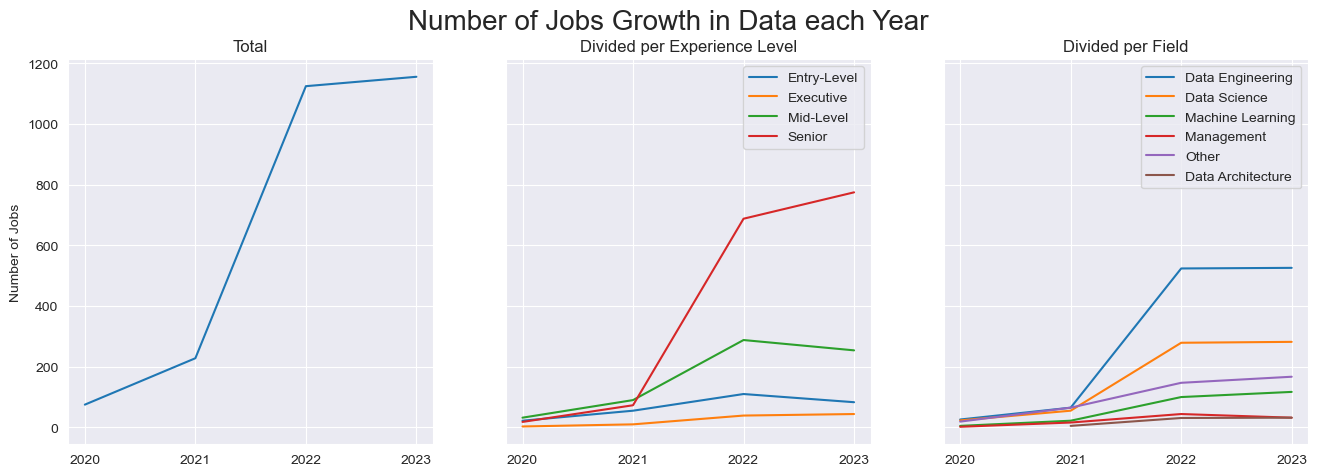

<Figure size 800x500 with 0 Axes>

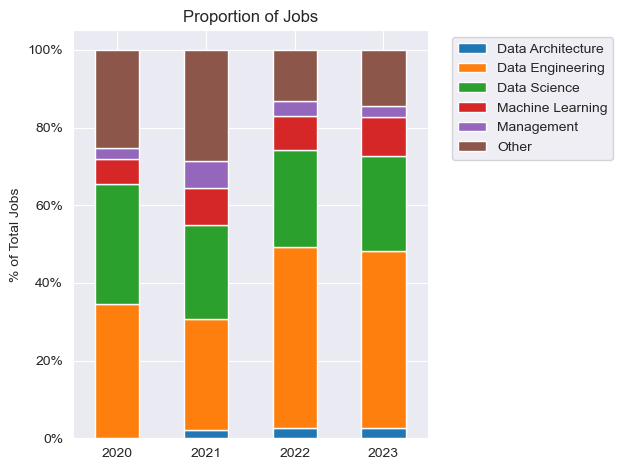

In [32]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# Count jobs by work year and experience level
counts_exp = data.groupby(by=['work_year', 'experience_level']).size().reset_index(name='counts')
counts_field = data.groupby(by=['work_year', 'job_category']).size().reset_index(name='counts')

# Creating the subplot
sns.set_style('darkgrid')
fig, axes = plt.subplots(1, 3, figsize=(16, 5), sharey=True)
fig.suptitle('Number of Jobs Growth in Data each Year', fontsize=20)

# Plotting the total number growth
total_counts = counts_exp.groupby('work_year')['counts'].sum().reset_index()
sns.lineplot(
    ax=axes[0],
    data=total_counts,
    x="work_year",
    y='counts',
    errorbar=None
)
axes[0].set_xticks(counts_exp['work_year'].unique())
axes[0].set_xlabel('')
axes[0].set_ylabel('Number of Jobs')
axes[0].set_title('Total')

# Plotting the growth per experience level
sns.lineplot(
    ax=axes[1],
    data=counts_exp,
    x="work_year",
    y='counts',
    hue='experience_level',
)
axes[1].set_xticks(counts_exp['work_year'].unique())
axes[1].set_xlabel('')
axes[1].set_ylabel('')
axes[1].set_title('Divided per Experience Level')
axes[1].legend(title='')

# Plotting the growth per field
sns.lineplot(
    ax=axes[2],
    data=counts_field,
    x="work_year",
    y='counts',
    hue='job_category',
)
axes[2].set_xticks(counts_field['work_year'].unique())
axes[2].set_xlabel('')
axes[2].set_ylabel('')
axes[2].set_title('Divided per Field')
axes[2].legend(title='')

# Plotting the proportions
plt.figure(figsize=(8, 5))  # Create a new figure for proportions
ax = data.groupby('work_year')['job_category'].value_counts(normalize=True).unstack('job_category').plot(kind='bar', stacked=True)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.set_xlabel('')
ax.set_title('Proportion of Jobs')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.set_ylabel('% of Total Jobs')

plt.tight_layout()
plt.show()


In [33]:
emp_salary = data.groupby('employment_type')['salary_in_usd'].mean()
emp_salary

employment_type
CT    113446.900000
FL     51807.800000
FT    134434.613271
PT     39533.705882
Name: salary_in_usd, dtype: float64

C:\Users\nipun\AppData\Local\Temp\ipykernel_27640\1997320841.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby(['employment_type', 'salary_category']).size()


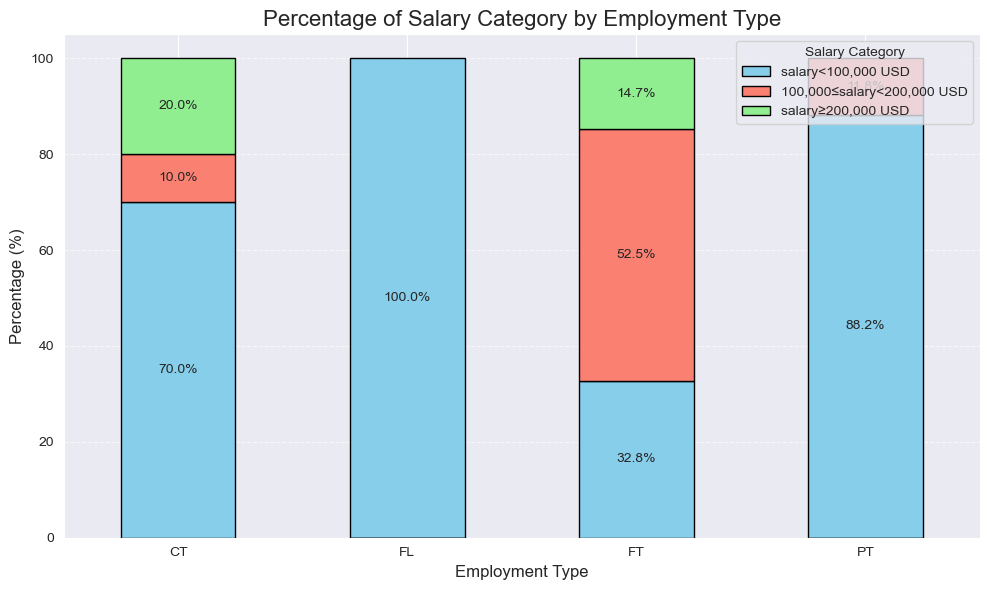

In [34]:
emp_salary = (
    data.groupby(['employment_type', 'salary_category']).size()
    .unstack(fill_value=0)
    .apply(lambda x: x / x.sum() * 100, axis=1)
)

# Plot the stacked bar chart
ax = emp_salary.plot(kind='bar', stacked=True, figsize=(10, 6), color=['skyblue', 'salmon', 'lightgreen'], edgecolor='black')

plt.title('Percentage of Salary Category by Employment Type', fontsize=16)
plt.xlabel('Employment Type', fontsize=12)
plt.ylabel('Percentage (%)', fontsize=12)
plt.xticks(rotation=0)

# Add percentages on each section of the bars
for i, bar in enumerate(ax.containers):
    for j, rect in enumerate(bar):
        height = rect.get_height()
        if height > 0:
            ax.text(
                rect.get_x() + rect.get_width() / 2,
                rect.get_y() + height / 2,
                f'{height:.1f}%',
                ha='center',
                va='center'
            )

plt.legend(title='Salary Category', loc='upper right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [35]:
emp_salary2 = data.groupby('experience_level')['salary_in_usd'].mean()
emp_salary2

experience_level
Entry-Level     72648.685185
Executive      191078.208333
Mid-Level      101828.783133
Senior         153897.435650
Name: salary_in_usd, dtype: float64

C:\Users\nipun\AppData\Local\Temp\ipykernel_27640\1255148056.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  salary_exp_counts = data.groupby(['experience_level', 'salary_category']).size().unstack(fill_value=0)


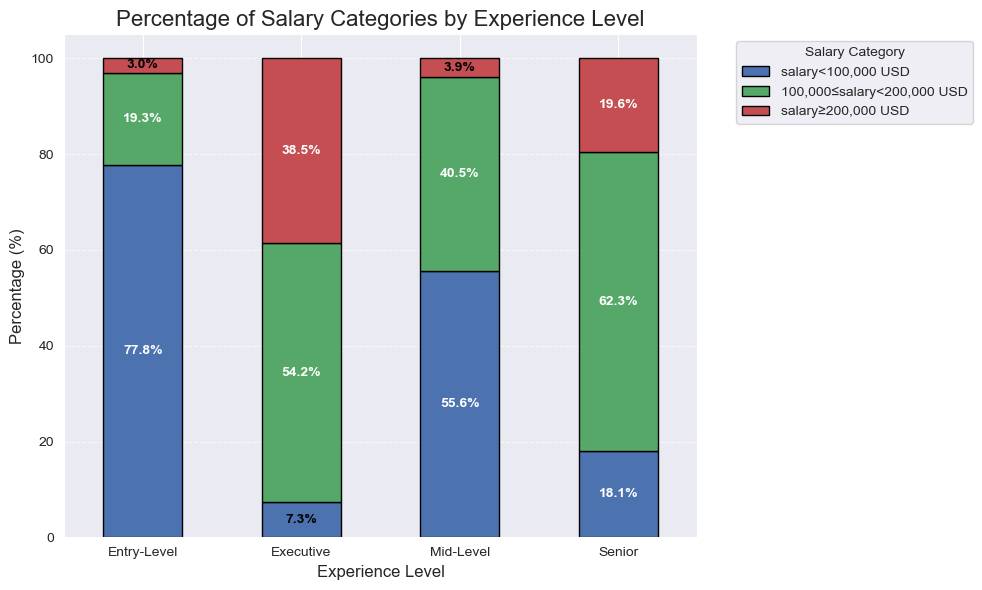

In [36]:
# Calculate the count of each salary category within each experience level
salary_exp_counts = data.groupby(['experience_level', 'salary_category']).size().unstack(fill_value=0)

# Convert counts to percentages within each experience level
salary_exp_percentages = salary_exp_counts.div(salary_exp_counts.sum(axis=1), axis=0) * 100

# Plot the stacked bar chart
ax = salary_exp_percentages.plot(
    kind='bar', 
    stacked=True, 
    color=['#4c72b0', '#55a868', '#c44e52'], 
    edgecolor='black',
    figsize=(10, 6)
)

# Add title and labels
plt.title('Percentage of Salary Categories by Experience Level', fontsize=16)
plt.xlabel('Experience Level', fontsize=12)
plt.ylabel('Percentage (%)', fontsize=12)

# Add percentage labels on each segment of the bars
for i, experience_level in enumerate(salary_exp_percentages.index):
    cumulative = 0  # Track cumulative height for each bar segment
    for j, (category, percentage) in enumerate(salary_exp_percentages.loc[experience_level].items()):
        if percentage > 0:  # Only label non-zero percentages
            cumulative += percentage
            ax.text(
                i,  # x position
                cumulative - (percentage / 2),  # y position
                f'{percentage:.1f}%', 
                ha='center', 
                va='center', 
                color='white' if percentage > 10 else 'black',  # Contrast for readability
                fontsize=10, 
                fontweight='bold'
            )

plt.xticks(rotation=0)
plt.legend(title='Salary Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [37]:
emp_salary3 = data.groupby('ratio_class')['salary_in_usd'].mean()
emp_salary3

ratio_class
Hybrid        78486.609626
In-Person    143690.173693
Remote       131821.666391
Name: salary_in_usd, dtype: float64

<Figure size 1000x600 with 0 Axes>

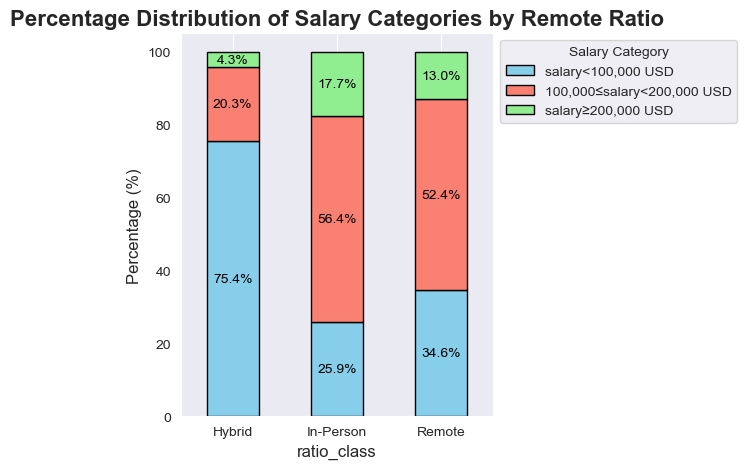

In [38]:
# Calculate the percentage of each salary category within each remote ratio
emp_salary_percent = (
    data.groupby('ratio_class')['salary_category']
    .value_counts(normalize=True)
    .rename('percentage')
    .reset_index()
)
emp_salary_percent['percentage'] *= 100  # Convert to percentage


emp_salary_pivot = emp_salary_percent.pivot(index='ratio_class', columns='salary_category', values='percentage')

# Plot the stacked bar chart
plt.figure(figsize=(10, 6))
emp_salary_pivot.plot(kind='bar', stacked=True, color=['skyblue', 'salmon', 'lightgreen'], edgecolor='black')

plt.title('Percentage Distribution of Salary Categories by Remote Ratio', fontsize=16, fontweight='bold')
plt.xlabel('ratio_class', fontsize=12)
plt.ylabel('Percentage (%)', fontsize=12)

# Add percentage labels on each section of the bars
for i, remote_ratio in enumerate(emp_salary_pivot.index):
    cumulative_percentage = 0
    for salary_category in emp_salary_pivot.columns:
        percentage = emp_salary_pivot.loc[remote_ratio, salary_category]
        if percentage > 0:
            plt.text(
                i, cumulative_percentage + percentage / 2,
                f"{percentage:.1f}%", ha='center', va='center', color="black", fontsize=10
            )
        cumulative_percentage += percentage

plt.xticks(rotation=0)  
plt.legend(title='Salary Category', loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [39]:
emp_salary4 = data.groupby('company_size')['salary_in_usd'].mean()
emp_salary4

company_size
Large     113202.239609
Medium    141474.514300
Small      78364.278912
Name: salary_in_usd, dtype: float64

C:\Users\nipun\AppData\Local\Temp\ipykernel_27640\1747794559.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = data.groupby(['company_size', 'salary_category']).size().reset_index(name='count')


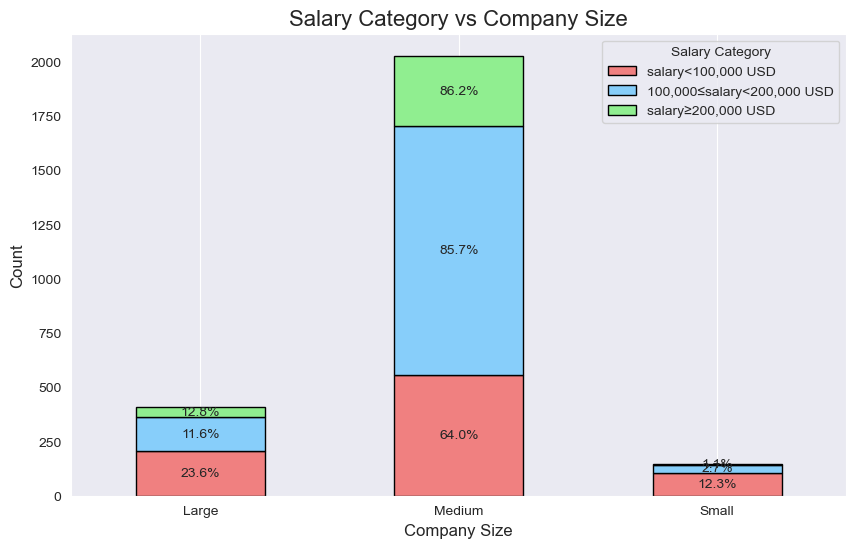

In [40]:
grouped_data = data.groupby(['company_size', 'salary_category']).size().reset_index(name='count')

# Pivot the data for stacking
pivot_df = grouped_data.pivot_table(index='company_size', columns='salary_category', values='count', fill_value=0)

# Create a stacked bar plot
ax = pivot_df.plot(kind='bar', stacked=True, figsize=(10, 6), color=['lightcoral', 'lightskyblue', 'lightgreen'], edgecolor='black')

# Calculate percentage and add to the bars
for container in ax.containers:
    labels = []
    for bar in container:
        height = bar.get_height()
        total = sum([bar.get_height() for bar in container])
        percentage = (height / total) * 100 if total > 0 else 0
        labels.append(f'{percentage:.1f}%')

    # Add percentage labels on the bars
    ax.bar_label(container, labels=labels, label_type='center')

# Adding titles and labels
plt.title('Salary Category vs Company Size', fontsize=16)
plt.xlabel('Company Size', fontsize=12)
plt.ylabel('Count', fontsize=12)

plt.xticks(rotation=0)  
plt.grid(axis='y')  
plt.legend(title='Salary Category')
plt.show()

In [41]:
emp_salary5 = data.groupby('company_location')['salary_in_usd'].mean()
emp_salary5

company_location
AE    100000.000000
AL     10000.000000
AM     50000.000000
AR     25000.000000
AS     29351.000000
          ...      
TH     23064.333333
TR     19058.000000
UA     57850.000000
US    152374.791602
VN     12000.000000
Name: salary_in_usd, Length: 72, dtype: float64

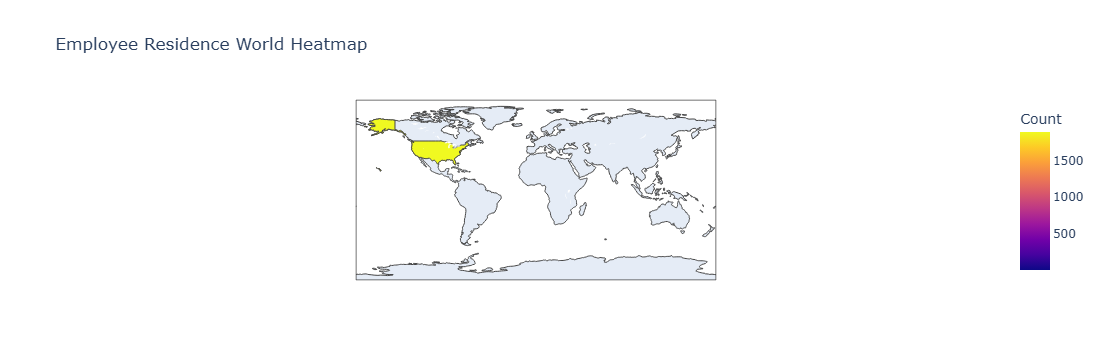

In [42]:
import plotly.express as px

# Grouping data to count occurrences by 'employee_residence'
data1 = {
    'Country': data.groupby('employee_residence').size().index.tolist(),
    'Count': data.groupby('employee_residence').size().tolist()
}

# Create DataFrame
df = pd.DataFrame(data1)

# Plotting the choropleth map
fig = px.choropleth(df,
                    locations='Country',
                    locationmode='country names',
                    color='Count',
                    hover_name='Country',
                    color_continuous_scale=px.colors.sequential.Plasma,
                    title='Employee Residence World Heatmap',
                    range_color=[df['Count'].min(), df['Count'].max()])  # Dynamic color scale range

# Show the plot
fig.show()


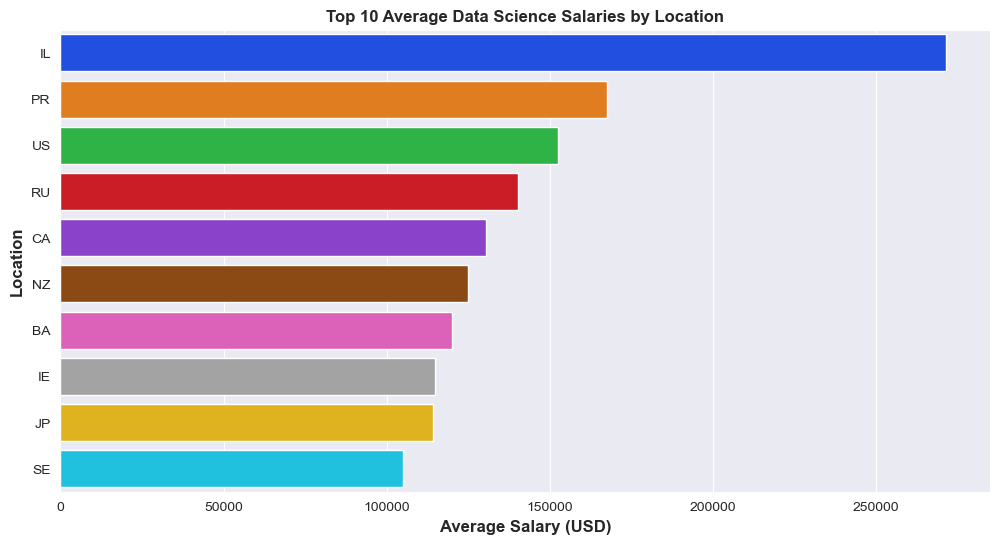

In [43]:
emp_salary5 = emp_salary5.sort_values(ascending=False)

emp_salary5_df = emp_salary5.reset_index()

top_n_locations = 10

plt.figure(figsize=(12, 6))
sns.barplot(x='salary_in_usd', y='company_location', data=emp_salary5_df.head(top_n_locations), palette='bright')

plt.title(f'Top {top_n_locations} Average Data Science Salaries by Location', fontsize=12, fontweight='bold')
plt.xlabel('Average Salary (USD)', fontsize=12, fontweight='bold')
plt.ylabel('Location', fontsize=12, fontweight='bold')

plt.show()


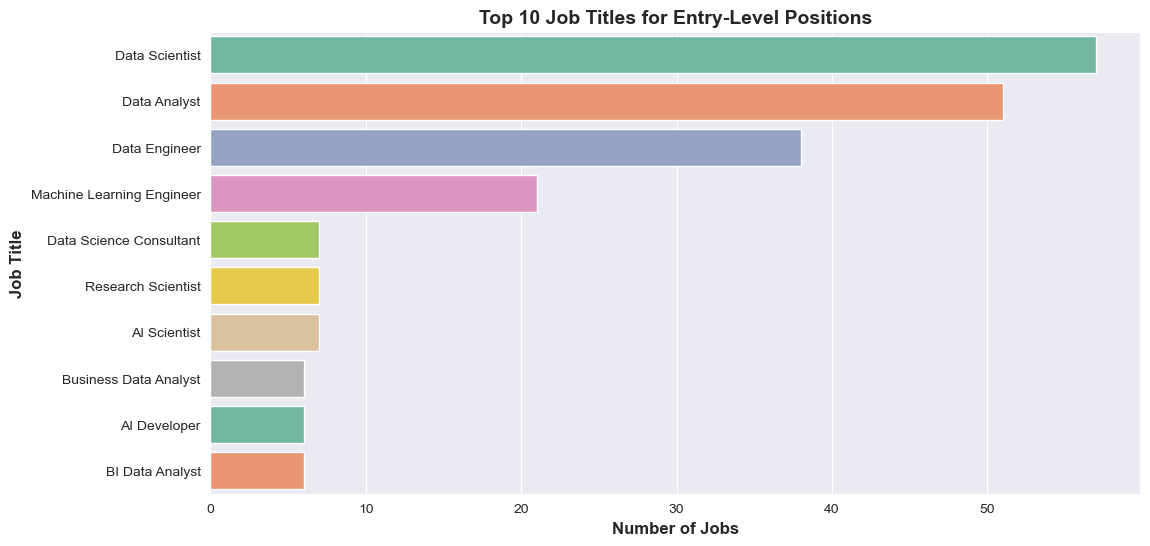

In [44]:
entry_level_jobs = data[data['experience_level'] == 'Entry-Level']

job_title_counts = entry_level_jobs['job_title'].value_counts().head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x=job_title_counts.values, y=job_title_counts.index, palette='Set2')

plt.title('Top 10 Job Titles for Entry-Level Positions', fontsize=14, fontweight='bold')
plt.xlabel('Number of Jobs', fontsize=12, fontweight='bold')
plt.ylabel('Job Title', fontsize=12, fontweight='bold')

plt.show()

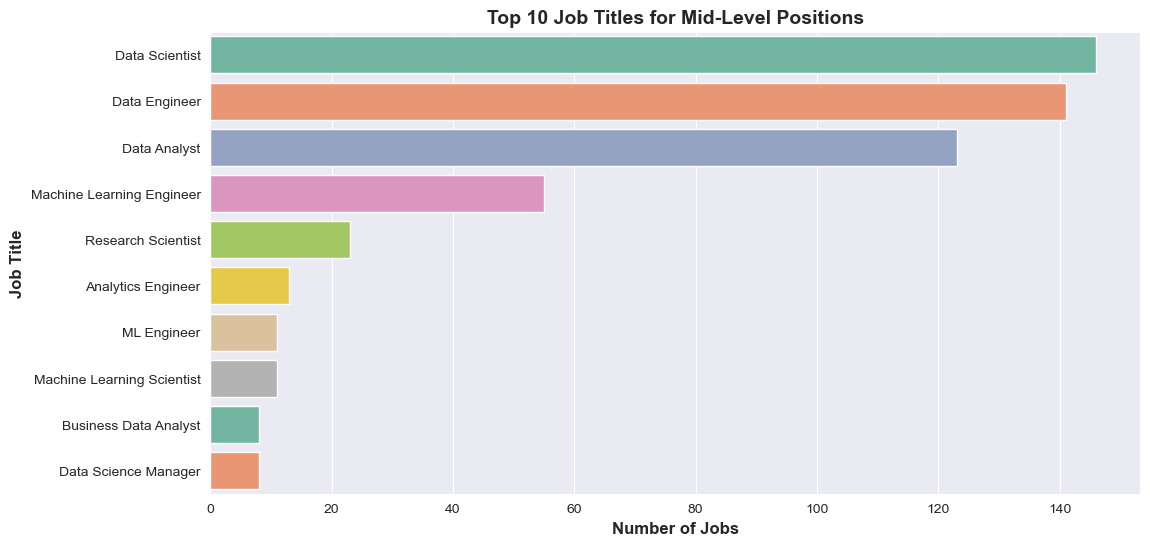

In [45]:
entry_level_jobs = data[data['experience_level'] == 'Mid-Level']

job_title_counts = entry_level_jobs['job_title'].value_counts().head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x=job_title_counts.values, y=job_title_counts.index, palette='Set2')

plt.title('Top 10 Job Titles for Mid-Level Positions', fontsize=14, fontweight='bold')
plt.xlabel('Number of Jobs', fontsize=12, fontweight='bold')
plt.ylabel('Job Title', fontsize=12, fontweight='bold')

plt.show()

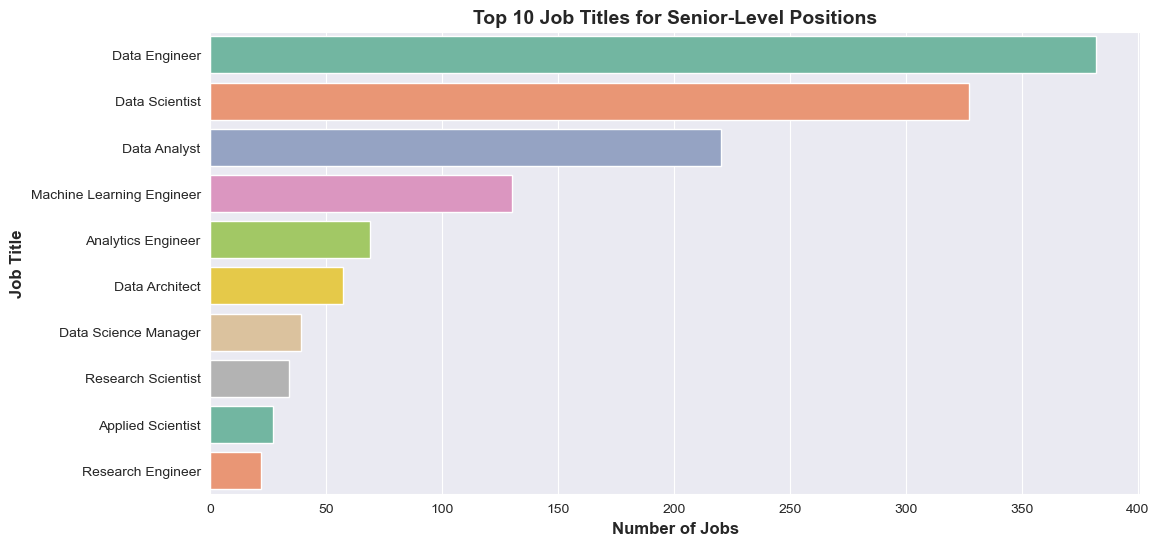

In [46]:
entry_level_jobs = data[data['experience_level'] == 'Senior']

job_title_counts = entry_level_jobs['job_title'].value_counts().head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x=job_title_counts.values, y=job_title_counts.index, palette='Set2')

plt.title('Top 10 Job Titles for Senior-Level Positions', fontsize=14, fontweight='bold')
plt.xlabel('Number of Jobs', fontsize=12, fontweight='bold')
plt.ylabel('Job Title', fontsize=12, fontweight='bold')

plt.show()

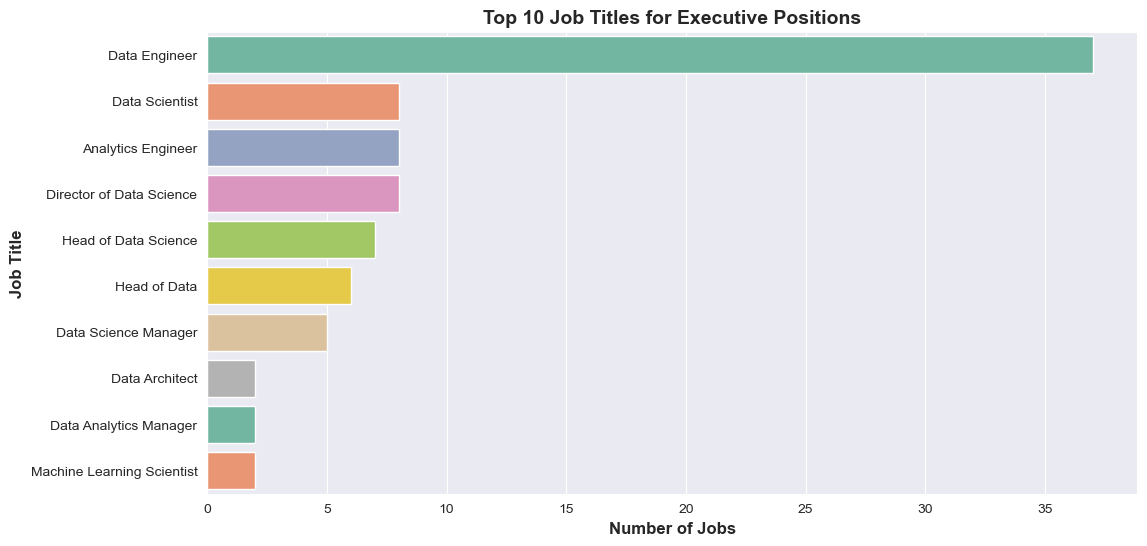

In [47]:
entry_level_jobs = data[data['experience_level'] == 'Executive']

job_title_counts = entry_level_jobs['job_title'].value_counts().head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x=job_title_counts.values, y=job_title_counts.index, palette='Set2')

plt.title('Top 10 Job Titles for Executive Positions', fontsize=14, fontweight='bold')
plt.xlabel('Number of Jobs', fontsize=12, fontweight='bold')
plt.ylabel('Job Title', fontsize=12, fontweight='bold')

plt.show()

               work_year    salary  salary_in_usd  remote_ratio
work_year       1.000000 -0.099153       0.236958     -0.219160
salary         -0.099153  1.000000      -0.043672      0.026485
salary_in_usd   0.236958 -0.043672       1.000000     -0.084502
remote_ratio   -0.219160  0.026485      -0.084502      1.000000


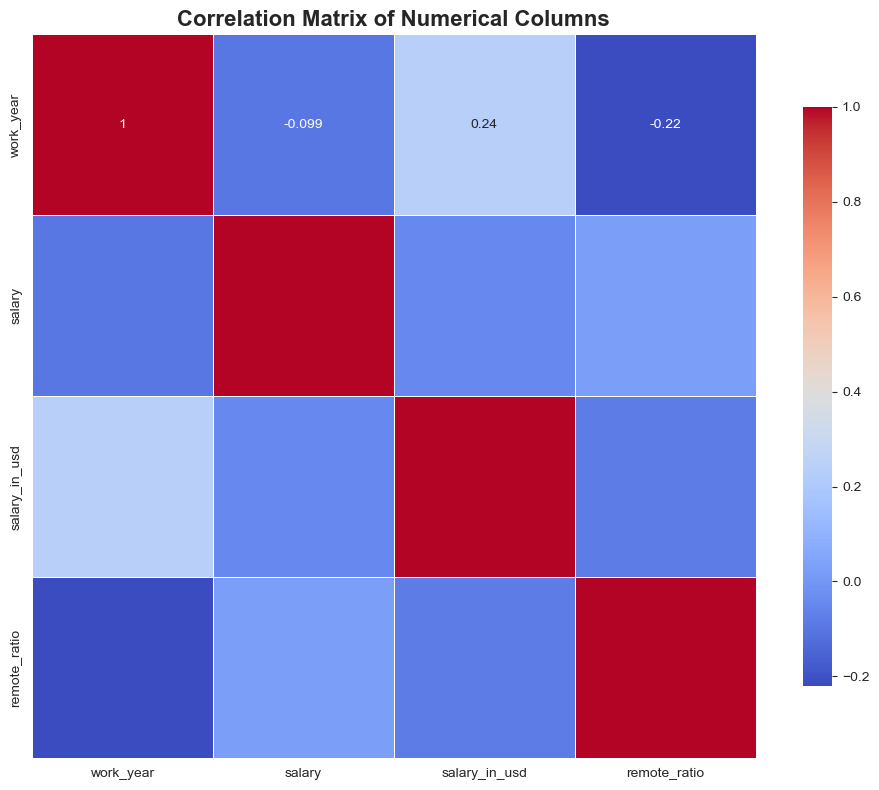

In [48]:
# Select only numerical columns (int and float types)
numerical_columns = data.select_dtypes(include=['int64', 'float64']).columns
numerical_data = data[numerical_columns]

# Calculate the correlation matrix for numerical columns only
correlation_matrix = numerical_data.corr()

# Print the correlation matrix
print(correlation_matrix)

# Set the size of the plot
plt.figure(figsize=(10, 8))

# Create a heatmap for the correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, square=True, cbar_kws={"shrink": .8})

# Set the title
plt.title('Correlation Matrix of Numerical Columns', fontsize=16, fontweight='bold')

# Show the plot with adjusted layout
plt.tight_layout()
plt.show()

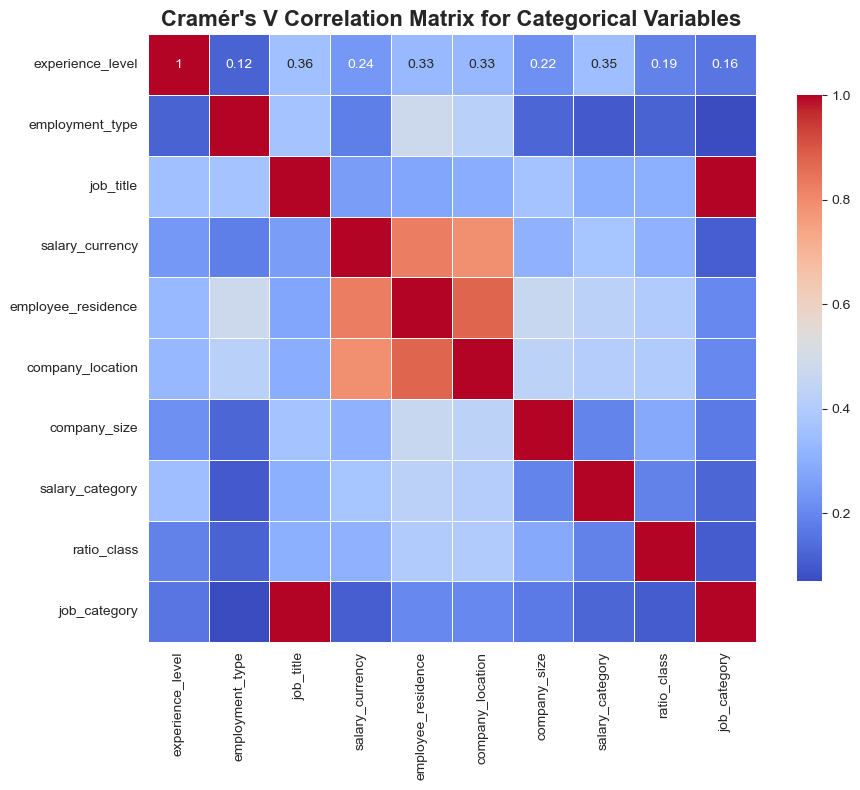

In [49]:
import scipy.stats as stats

# Function to calculate Cramér's V
def cramers_v(confusion_matrix):
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    r, k = confusion_matrix.shape
    return np.sqrt(chi2 / (n * (min(k, r) - 1)))

# Ensure that categorical columns selected
categorical_columns = data.select_dtypes(include=['object', 'category']).columns

# Initialize an empty DataFrame to hold Cramér's V values
cramers_v_matrix = pd.DataFrame(index=categorical_columns, columns=categorical_columns, dtype=float)

# Calculate Cramér's V for each pair of categorical variables
for col1 in categorical_columns:
    for col2 in categorical_columns:
        if col1 == col2:
            cramers_v_matrix.loc[col1, col2] = 1.0  # Perfect correlation with itself
        else:
            confusion_matrix = pd.crosstab(data[col1], data[col2])
            cramers_v_matrix.loc[col1, col2] = cramers_v(confusion_matrix)

# Plotting the Cramér's V matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cramers_v_matrix, annot=True, cmap='coolwarm', linewidths=0.5, square=True, cbar_kws={"shrink": .8})

plt.title("Cramér's V Correlation Matrix for Categorical Variables", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()


In [50]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler

X = data[numerical_columns]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

vif_data = pd.DataFrame()
vif_data["feature"] = numerical_columns

vif_data["VIF"] = [variance_inflation_factor(X_scaled, i) for i in range(X_scaled.shape[1])]

print(vif_data)

         feature       VIF
0      work_year  1.115078
1         salary  1.010387
2  salary_in_usd  1.061197
3   remote_ratio  1.051715


## Model Fiiting

In [51]:
data.head()

work_year experience_level employment_type                 job_title  \
0       2023           Senior              FT  Principal Data Scientist   
1       2023        Mid-Level              CT               ML Engineer   
2       2023        Mid-Level              CT               ML Engineer   
3       2023           Senior              FT            Data Scientist   
4       2023           Senior              FT            Data Scientist   

   salary salary_currency  salary_in_usd employee_residence  remote_ratio  \
0   80000             EUR          85847                 ES           100   
1   30000             USD          30000                 US           100   
2   25500             USD          25500                 US           100   
3  175000             USD         175000                 CA           100   
4  120000             USD         120000                 CA           100   

  company_location company_size             salary_category ratio_class  \
0               ES        Large          salary<100,000 USD      Remote   
1               US        Small          salary<100,000 USD      Remote   
2               US        Small          salary<100,000 USD      Remote   
3               CA       Medium  100,000≤salary<200,000 USD      Remote   
4               CA       Medium  100,000≤salary<200,000 USD      Remote   

       job_category  
0             Other  
1  Machine Learning  
2  Machine Learning  
3      Data Science  
4      Data Science

In [52]:
data.drop(['salary_in_usd','job_title','remote_ratio','salary'],axis=1,inplace= True)
data.head()

work_year experience_level employment_type salary_currency  \
0       2023           Senior              FT             EUR   
1       2023        Mid-Level              CT             USD   
2       2023        Mid-Level              CT             USD   
3       2023           Senior              FT             USD   
4       2023           Senior              FT             USD   

  employee_residence company_location company_size  \
0                 ES               ES        Large   
1                 US               US        Small   
2                 US               US        Small   
3                 CA               CA       Medium   
4                 CA               CA       Medium   

              salary_category ratio_class      job_category  
0          salary<100,000 USD      Remote             Other  
1          salary<100,000 USD      Remote  Machine Learning  
2          salary<100,000 USD      Remote  Machine Learning  
3  100,000≤salary<200,000 USD      Remote      Data Science  
4  100,000≤salary<200,000 USD      Remote      Data Science

In [53]:
from sklearn.preprocessing import OrdinalEncoder

# Initialize the OrdinalEncoder
ordinal_encoder = OrdinalEncoder(categories=[['salary<100,000 USD', '100,000≤salary<200,000 USD', 'salary≥200,000 USD']])

# Fit and transform the salary_category column
data['salary_category_numeric'] = ordinal_encoder.fit_transform(data[['salary_category']]).astype(int) + 1

# Display the result
data[['salary_category', 'salary_category_numeric']].head()


salary_category  salary_category_numeric
0          salary<100,000 USD                        1
1          salary<100,000 USD                        1
2          salary<100,000 USD                        1
3  100,000≤salary<200,000 USD                        2
4  100,000≤salary<200,000 USD                        2

In [54]:
data.drop(['salary_category'],axis=1,inplace= True)
data.head()

work_year experience_level employment_type salary_currency  \
0       2023           Senior              FT             EUR   
1       2023        Mid-Level              CT             USD   
2       2023        Mid-Level              CT             USD   
3       2023           Senior              FT             USD   
4       2023           Senior              FT             USD   

  employee_residence company_location company_size ratio_class  \
0                 ES               ES        Large      Remote   
1                 US               US        Small      Remote   
2                 US               US        Small      Remote   
3                 CA               CA       Medium      Remote   
4                 CA               CA       Medium      Remote   

       job_category  salary_category_numeric  
0             Other                        1  
1  Machine Learning                        1  
2  Machine Learning                        1  
3      Data Science                        2  
4      Data Science                        2

In [55]:
data = pd.get_dummies(data,columns=['experience_level','salary_currency','employment_type', 'employee_residence', 'company_location', 'company_size','job_category','ratio_class'],dtype=int)

In [56]:
data.head()

work_year  salary_category_numeric  experience_level_Entry-Level  \
0       2023                        1                             0   
1       2023                        1                             0   
2       2023                        1                             0   
3       2023                        2                             0   
4       2023                        2                             0   

   experience_level_Executive  experience_level_Mid-Level  \
0                           0                           0   
1                           0                           1   
2                           0                           1   
3                           0                           0   
4                           0                           0   

   experience_level_Senior  salary_currency_AUD  salary_currency_BRL  \
0                        1                    0                    0   
1                        0                    0                    0   
2                        0                    0                    0   
3                        1                    0                    0   
4                        1                    0                    0   

   salary_currency_CAD  salary_currency_CHF  ...  company_size_Small  \
0                    0                    0  ...                   0   
1                    0                    0  ...                   1   
2                    0                    0  ...                   1   
3                    0                    0  ...                   0   
4                    0                    0  ...                   0   

   job_category_Data Architecture  job_category_Data Engineering  \
0                               0                              0   
1                               0                              0   
2                               0                              0   
3                               0                              0   
4                               0                              0   

   job_category_Data Science  job_category_Machine Learning  \
0                          0                              0   
1                          0                              1   
2                          0                              1   
3                          1                              0   
4                          1                              0   

   job_category_Management  job_category_Other  ratio_class_Hybrid  \
0                        0                   1                   0   
1                        0                   0                   0   
2                        0                   0                   0   
3                        0                   0                   0   
4                        0                   0                   0   

   ratio_class_In-Person  ratio_class_Remote  
0                      0                   1  
1                      0                   1  
2                      0                   1  
3                      0                   1  
4                      0                   1  

[5 rows x 192 columns]

In [57]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2584 entries, 0 to 3754
Columns: 192 entries, work_year to ratio_class_Remote
dtypes: int32(191), int64(1)
memory usage: 1.9 MB


In [58]:
X = data.drop('salary_category_numeric',axis=1)
y = data['salary_category_numeric']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.20, random_state=42)

In [59]:
from sklearn.model_selection import train_test_split 
from sklearn.metrics import classification_report, confusion_matrix 
from collections import Counter
print("Original class distribution:", Counter(y)) 

Original class distribution: Counter({2: 1341, 1: 867, 3: 376})


In [60]:
from collections import Counter
from imblearn.over_sampling import SMOTE

# Initialize SMOTE
smote = SMOTE(random_state=42)

# Fit and resample the training data
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Print the class distribution of the resampled data
print("SMOTE class distribution:", Counter(y_resampled))

# Optional: You can also print the shape of the resampled dataset
print("Resampled X shape:", X_resampled.shape)
print("Resampled y shape:", y_resampled.shape)


SMOTE class distribution: Counter({3: 1081, 1: 1081, 2: 1081})
Resampled X shape: (3243, 191)
Resampled y shape: (3243,)


In [61]:
print("Unique classes in y_resampled:", np.unique(y_resampled))

Unique classes in y_resampled: [1 2 3]


In [62]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
import mord as m
import warnings
warnings.simplefilter(action='ignore')

# Define models with parameter grids for hyperparameter tuning
model_params = {
    'Ordinal Logistic Regression': {
        'model': m.LogisticAT(),  # Using Mord's LogisticAT for ordinal regression
        'params': {
            'alpha': [0.1, 0.5, 1.0]  # Regularization parameter
        }
    },
    'Random Forest': {
        'model': RandomForestClassifier(),
        'params': {
            'n_estimators': [50, 100, 200],
            'max_depth': [5, 10, 15]
        }
    },
    'GaussianNB': {
        'model': GaussianNB(),
        'params': {}
    },
    'AdaBoost': {
        'model': AdaBoostClassifier(),
        'params': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 1]
        }
    },
    'Gradient Boosting': {
        'model': GradientBoostingClassifier(),
        'params': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.5],
            'max_depth': [3, 5, 7]
        }
    }
   
}

# Loop through each model and perform hyperparameter tuning with GridSearchCV
for name, model_dict in model_params.items():
    print(f"Training {name} with hyperparameter tuning...")
    grid_search = GridSearchCV(model_dict['model'], model_dict['params'], cv=5, scoring='accuracy')
    
    # Fit with the resampled SMOTE data
    grid_search.fit(X_resampled, y_resampled)
    
    best_model = grid_search.best_estimator_
    
    # Training predictions and metrics
    train_pred = best_model.predict(X_resampled)
    train_acc = accuracy_score(y_resampled, train_pred)
    train_err = 1 - train_acc
    train_f1 = f1_score(y_resampled, train_pred, average='weighted')
    train_cm = confusion_matrix(y_resampled, train_pred)
    train_sensitivity = train_cm[1, 1] / (train_cm[1, 1] + train_cm[1, 0]) if (train_cm[1, 1] + train_cm[1, 0]) != 0 else 0
    train_specificity = train_cm[0, 0] / (train_cm[0, 0] + train_cm[0, 1]) if (train_cm[0, 0] + train_cm[0, 1]) != 0 else 0
    
    # Test predictions and metrics
    test_pred = best_model.predict(X_test)
    test_acc = accuracy_score(y_test, test_pred)
    test_err = 1 - test_acc
    test_f1 = f1_score(y_test, test_pred, average='weighted')
    test_cm = confusion_matrix(y_test, test_pred)
    test_sensitivity = test_cm[1, 1] / (test_cm[1, 1] + test_cm[1, 0]) if (test_cm[1, 1] + test_cm[1, 0]) != 0 else 0
    test_specificity = test_cm[0, 0] / (test_cm[0, 0] + test_cm[0, 1]) if (test_cm[0, 0] + test_cm[0, 1]) != 0 else 0
    
    # Print results
    print(name)
    print('=' * len(name))
    print(f'Best Parameters: {grid_search.best_params_}')
    print(f'Training Accuracy: {train_acc:.4f}')
    print(f'Training Error Rate: {train_err:.4f}')
    print(f'Training F1 Score: {train_f1:.4f}')
    print(f'Training Confusion Matrix:\n{train_cm}')
    print(f'Training Sensitivity: {train_sensitivity:.4f}')
    print(f'Training Specificity: {train_specificity:.4f}')
    print('\n')
    print(f'Test Accuracy: {test_acc:.4f}')
    print(f'Test Error Rate: {test_err:.4f}')
    print(f'Test F1 Score: {test_f1:.4f}')
    print(f'Test Confusion Matrix:\n{test_cm}')
    print(f'Test Sensitivity: {test_sensitivity:.4f}')
    print(f'Test Specificity: {test_specificity:.4f}')
    print('\n' + '=' * 30 + '\n')


Training Ordinal Logistic Regression with hyperparameter tuning...
Ordinal Logistic Regression
Best Parameters: {'alpha': 0.1}
Training Accuracy: 0.6241
Training Error Rate: 0.3759
Training F1 Score: 0.6324
Training Confusion Matrix:
[[754 274  53]
 [ 93 714 274]
 [  8 517 556]]
Training Sensitivity: 0.8848
Training Specificity: 0.7335


Test Accuracy: 0.5667
Test Error Rate: 0.4333
Test F1 Score: 0.5847
Test Confusion Matrix:
[[110  60   9]
 [ 22 153  85]
 [  2  46  30]]
Test Sensitivity: 0.8743
Test Specificity: 0.6471


Training Random Forest with hyperparameter tuning...
Random Forest
Best Parameters: {'max_depth': 15, 'n_estimators': 100}
Training Accuracy: 0.7021
Training Error Rate: 0.2979
Training F1 Score: 0.7034
Training Confusion Matrix:
[[815 141 125]
 [ 56 575 450]
 [  0 194 887]]
Training Sensitivity: 0.9113
Training Specificity: 0.8525


Test Accuracy: 0.5184
Test Error Rate: 0.4816
Test F1 Score: 0.5463
Test Confusion Matrix:
[[117  43  19]
 [ 20 106 134]
 [  2  31  45]

In [63]:
# Remap target labels
y_resampled_mapped = y_resampled - 1
y_test_mapped = y_test - 1

# Define XGBoost model with parameter grid for hyperparameter tuning
xgb_model_params = {
    'model': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),
    'params': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.5],
        'max_depth': [3, 5, 7]
    }
}

# Perform hyperparameter tuning with GridSearchCV
print("Training XGBoost with hyperparameter tuning...")
grid_search = GridSearchCV(xgb_model_params['model'], xgb_model_params['params'], cv=5, scoring='accuracy')
grid_search.fit(X_resampled, y_resampled_mapped)

best_model = grid_search.best_estimator_

# Training predictions and metrics
train_pred = best_model.predict(X_resampled)
train_acc = accuracy_score(y_resampled_mapped, train_pred)
train_err = 1 - train_acc
train_f1 = f1_score(y_resampled_mapped, train_pred, average='weighted')
train_cm = confusion_matrix(y_resampled_mapped, train_pred)
train_sensitivity = train_cm[1, 1] / (train_cm[1, 1] + train_cm[1, 0]) if (train_cm[1, 1] + train_cm[1, 0]) != 0 else 0
train_specificity = train_cm[0, 0] / (train_cm[0, 0] + train_cm[0, 1]) if (train_cm[0, 0] + train_cm[0, 1]) != 0 else 0

# Test predictions and metrics
test_pred = best_model.predict(X_test)
test_acc = accuracy_score(y_test_mapped, test_pred)
test_err = 1 - test_acc
test_f1 = f1_score(y_test_mapped, test_pred, average='weighted')
test_cm = confusion_matrix(y_test_mapped, test_pred)
test_sensitivity = test_cm[1, 1] / (test_cm[1, 1] + test_cm[1, 0]) if (test_cm[1, 1] + test_cm[1, 0]) != 0 else 0
test_specificity = test_cm[0, 0] / (test_cm[0, 0] + test_cm[0, 1]) if (test_cm[0, 0] + test_cm[0, 1]) != 0 else 0

# Print results
print("XGBoost")
print("=" * len("XGBoost"))
print(f'Best Parameters: {grid_search.best_params_}')
print(f'Training Accuracy: {train_acc:.4f}')
print(f'Training Error Rate: {train_err:.4f}')
print(f'Training F1 Score: {train_f1:.4f}')
print(f'Training Confusion Matrix:\n{train_cm}')
print(f'Training Sensitivity: {train_sensitivity:.4f}')
print(f'Training Specificity: {train_specificity:.4f}')
print('\n')
print(f'Test Accuracy: {test_acc:.4f}')
print(f'Test Error Rate: {test_err:.4f}')
print(f'Test F1 Score: {test_f1:.4f}')
print(f'Test Confusion Matrix:\n{test_cm}')
print(f'Test Sensitivity: {test_sensitivity:.4f}')
print(f'Test Specificity: {test_specificity:.4f}')
print('\n' + '=' * 30 + '\n')


Training XGBoost with hyperparameter tuning...
XGBoost
Best Parameters: {'learning_rate': 0.5, 'max_depth': 5, 'n_estimators': 50}
Training Accuracy: 0.6916
Training Error Rate: 0.3084
Training F1 Score: 0.6923
Training Confusion Matrix:
[[812 141 128]
 [ 78 564 439]
 [  3 211 867]]
Training Sensitivity: 0.8785
Training Specificity: 0.8520


Test Accuracy: 0.5029
Test Error Rate: 0.4971
Test F1 Score: 0.5279
Test Confusion Matrix:
[[108  50  21]
 [ 25 106 129]
 [  2  30  46]]
Test Sensitivity: 0.8092
Test Specificity: 0.6835




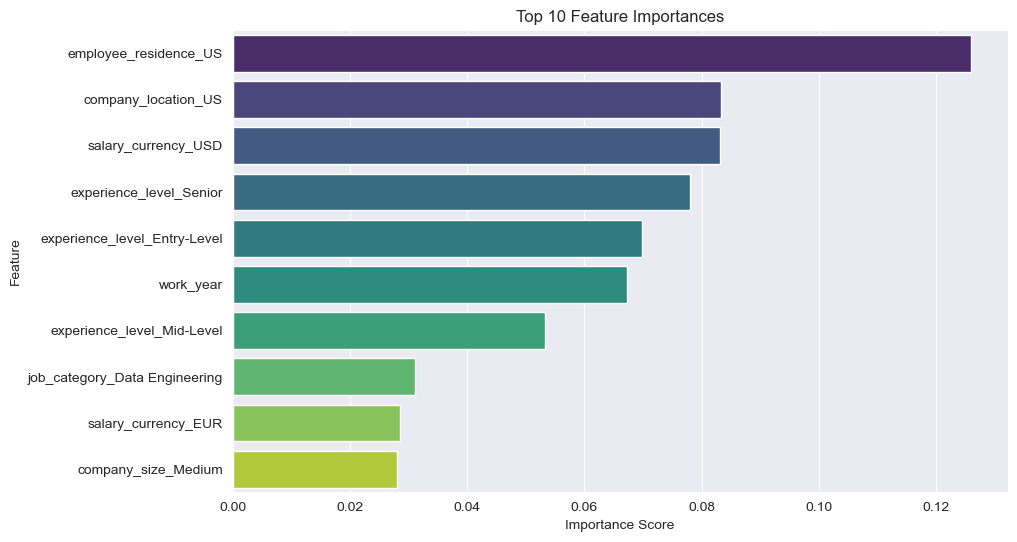

In [64]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier

# Train the Random Forest model on the training data with the best parameters
random_forest = RandomForestClassifier(n_estimators=50, max_depth=15, random_state=42)
random_forest.fit(X_resampled, y_resampled)

# Get feature importances
feature_importances = random_forest.feature_importances_
features = X_resampled.columns  

# Create a DataFrame to store feature names and their importance scores
feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Select the top 10 features
top_features = feature_importance_df.head(10)

# Plot feature importance using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=top_features, palette="viridis")
plt.title('Top 10 Feature Importances')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()


## Shap

In [68]:
from sklearn.inspection import PartialDependenceDisplay
from yellowbrick.regressor import prediction_error
import shap
import lime
import lime.lime_tabular 
from lime import submodular_pick
from sklearn.inspection import PartialDependenceDisplay

In [69]:
explainer = shap.TreeExplainer(random_forest)

In [70]:
shap_values = explainer.shap_values(X_test)

In [71]:
shap_values[:, :, 0].shape

(517, 191)

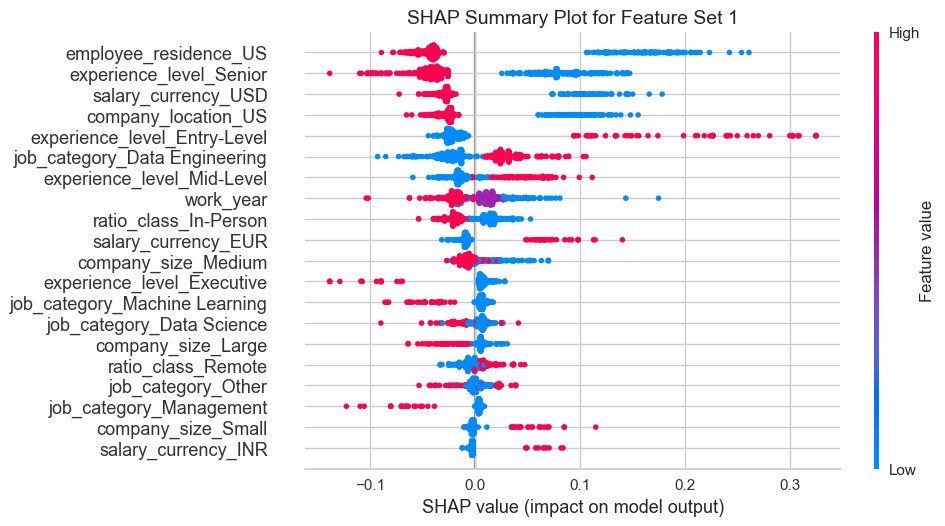

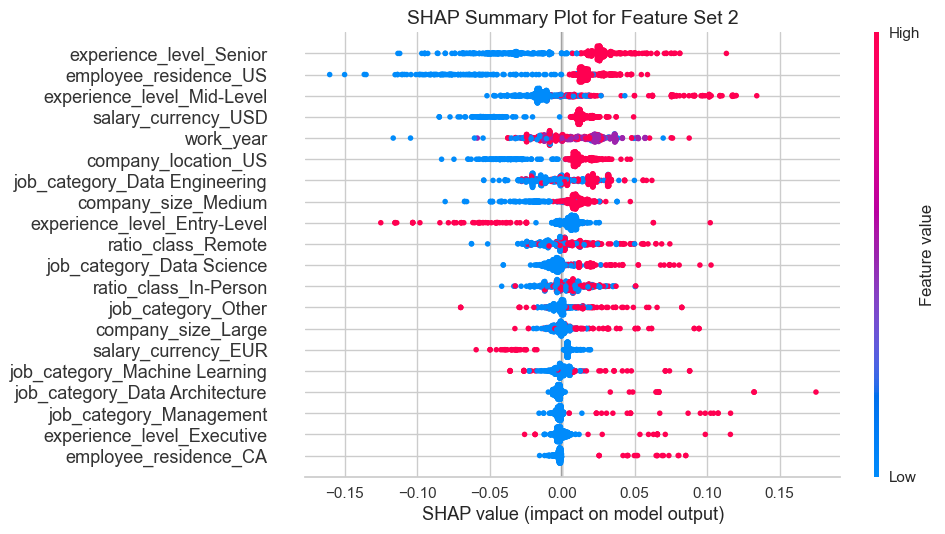

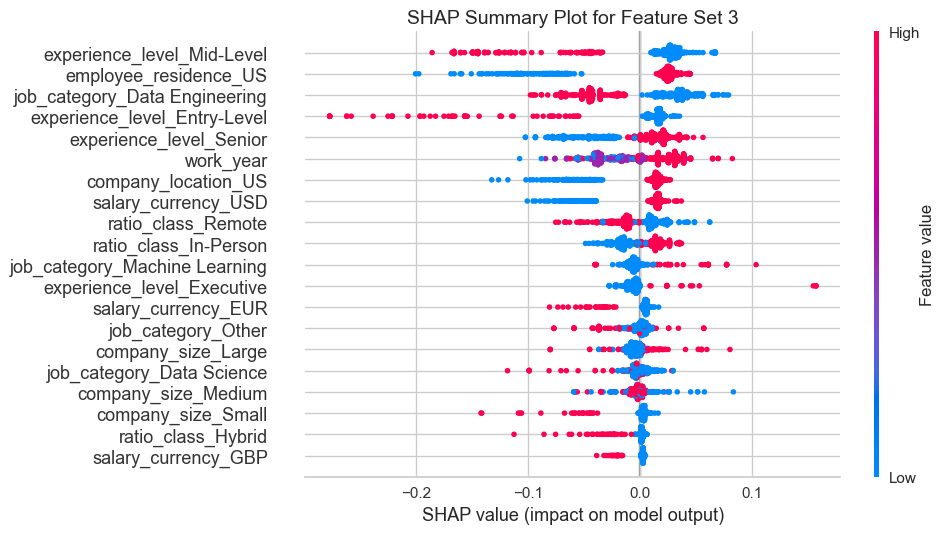

<Figure size 800x550 with 0 Axes>

In [78]:
plt.figure(figsize=(5, 15))
for idx in range(3):
    plt.subplot(3, 1, idx+1)
    plt.title(f"SHAP Summary Plot for Feature Set {idx + 1}", fontsize=14) 
    shap.summary_plot(shap_values[:, :, idx],X_test, title="dfd", plot_size=(10, 15))
    plt.tight_layout()
    

plt.show()

In [79]:
### Create a Pickle file using seralization
import pickle
pickle_out = open("random_forest.pkl","wb")
pickle.dump(random_forest,pickle_out)
pickle_out.close()